# UBS Feature Selection

In this section we will continute data preprocessing steps in order to facilitate feature selection critera

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

In [2]:
# read in full UBS dataset (2019 - 2022)
df = pd.read_csv("UBS_Cleaned_Date.csv")

In [3]:
# Change "date" column to ensure datetime type and drop weekends
df["date"] = pd.to_datetime(df["date"])

In [4]:
# Drop first 14 dates
df = df.iloc[14:-1, :].reset_index(drop = True)
df.shape

(796, 201)

In [5]:
# Remove any infinitly large or small values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [6]:
# Drop remanining NaN or null values
df = df.dropna()
df.shape

(748, 201)

In [7]:
# Create X feature dataset
X = df.drop(["date", "target_1", "target_2", "target_3", "target_4", "target_5"], axis=1)

# Create y target dataset
y = df["target_1"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Lasso Regression

Use lasso regression to find which features have coefficeints significantly different than zero. Those that are should be considered for inclusion in the models

In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

search = GridSearchCV(pipeline,
                       {'model__alpha': np.arange(0.1, 10, 0.1)},
                        cv=10,
scoring = 'neg_mean_squared_error', verbose = 3
)

search.fit(X_train, y_train)
search.best_params_

coefficients = search.best_estimator_.named_steps['model'].coef_

importance = np.abs(coefficients)
importance

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV 1/10] END ..............................model__alpha=0.1; total time=   1.3s
[CV 2/10] END ..............................model__alpha=0.1; total time=   0.1s
[CV 3/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 4/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 5/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 6/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 7/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 8/10] END ..............................model__alpha=0.1; total time=   0.0s
[CV 9/10] END ..............................model__alpha=0.1; total time=   0.1s
[CV 10/10] END .............................model__alpha=0.1; total time=   0.0s
[CV 1/10] END ..............................model__alpha=0.2; total time=   0.0s
[CV 2/10] END ..............................mo

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16897186, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### SelectKBest 

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# scale the data to be between 0 and 1. Chi2 doesn't allow for negative values


# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
best_fit = bestfeatures.fit(X, y)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(X.columns)

# concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score']  # naming the dataframe columns
print(features_score.nlargest(25, 'Score'))  # print the top 10 best features

                    Features       Score
56              Change_Close  313.546149
66             Wiki_RSI_Move    7.953919
192       Dow_Disparity_Move    5.951264
59            Wiki_MAvg_Move    5.017463
154                 Nas_Move    4.581971
88                 Google_rs    4.294823
93           Google_ROC_Move    4.061060
160       Nas_Disparity_Move    3.780974
97   Google_Disparity_s_Move    3.778765
161     Nas_Disparity_s_Move    3.604700
84               Google_gain    3.385177
193     Dow_Disparity_s_Move    3.349542
98           Google_RSI_Move    3.227221
83               Google_diff    3.168724
186                 Dow_Move    2.980363
70         Google_Moment_2_s    2.105778
176                 Dow_Rocp    2.044336
148                 Nas_gain    2.039677
40          Wiki_Disparity_s    2.005270
156          Nas_MAvg_s_Move    1.989034
90               Google_Move    1.908364
76        Google_Disparity_s    1.877253
27              Google_total    1.842870
12              

/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


### Feature Importance with ExtraTreesClassifier

[0.00723825 0.00040948 0.00296896 0.00012536 0.0034258  0.00427651
 0.00345292 0.00467769 0.00455277 0.00580875 0.00020998 0.
 0.00501479 0.00576903 0.004636   0.00465382 0.00451704 0.00485215
 0.00408809 0.00388    0.00404371 0.00397566 0.00425843 0.00426842
 0.00446718 0.00515546 0.00425812 0.0055875  0.00475666 0.0040661
 0.00443226 0.00606394 0.00461517 0.00497747 0.00476326 0.00490648
 0.00508228 0.0050053  0.00498158 0.00446661 0.00513999 0.00526603
 0.00498449 0.00469968 0.00650434 0.00431376 0.00443804 0.00517207
 0.00454682 0.00547513 0.00456091 0.0052071  0.00512868 0.00675757
 0.00688625 0.00592695 0.06066681 0.004601   0.00482986 0.00622883
 0.00427485 0.00593666 0.00469191 0.00374291 0.00436487 0.00493011
 0.00891188 0.00569203 0.00622064 0.00615659 0.00577151 0.00546844
 0.00526946 0.00481182 0.00533434 0.00590889 0.00517092 0.00593603
 0.00488173 0.00580152 0.00597254 0.00490602 0.00602429 0.00562733
 0.00450259 0.00446166 0.00558335 0.00535261 0.00536441 0.00604282
 0.0

<AxesSubplot:>

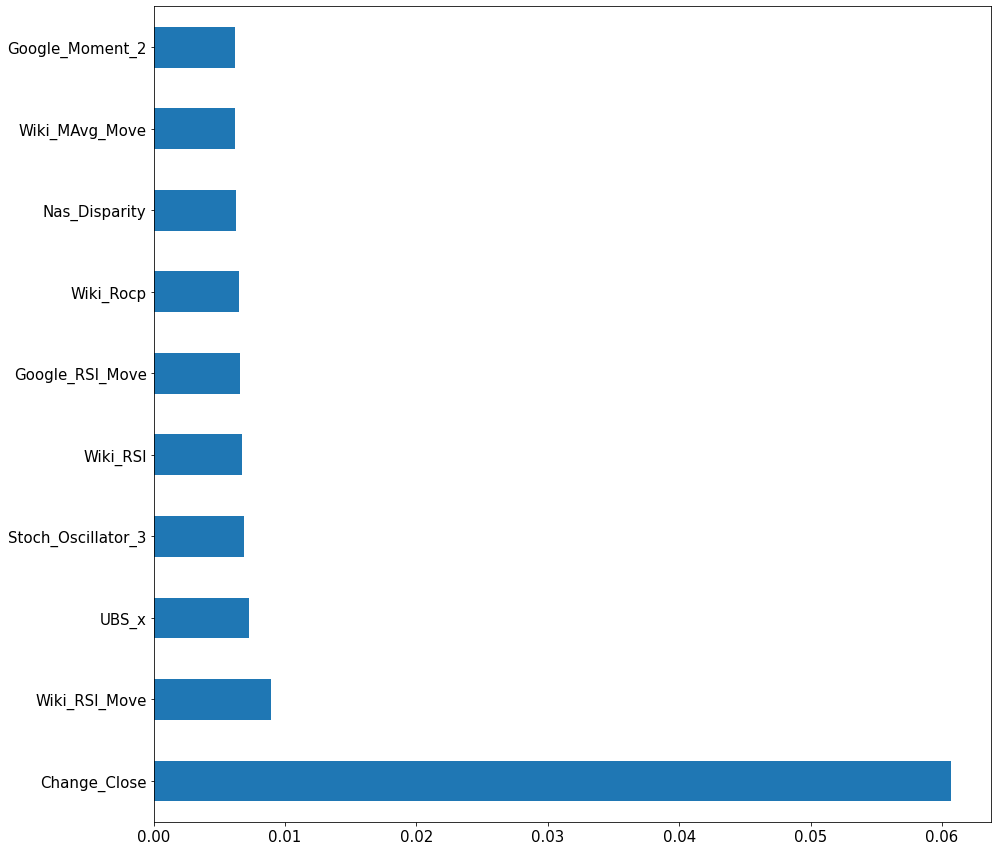

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(15,15), fontsize=(15))